# BLU05 - Learning Notebook - Part 1 of 3 - Time Series Components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (16, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
seed(1)

from utils import load_electricity_consumption_series
from utils import load_airlines_series
%matplotlib inline

In the previous BLU you learned fundamental concepts to start modelling time series, in this BLU you'll finally learn how to actually model them. For that, we're going to dive a bit deeper into their components using a very useful library: _statsmodels_.

As you may have come to realize, timeseries are sneaky things. Sometimes noise looks like signal, and signal looks like noise. 

A frequent problem with timeseries is answering the open, yet crucial question: _"is there any kind of signal here?"_ 

The first thing to do, as always, is to ~~run a highly complex LSTM analysis on the deep learning blockchain~~ **plot the data**

In [2]:
airlines = load_airlines_series()

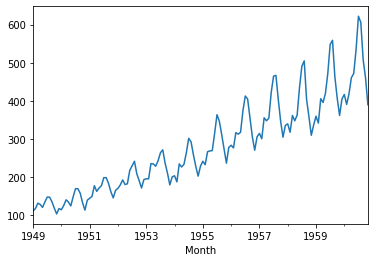

In [3]:
airlines.plot();

## 1. Seasonal Decomposition

In the previous BLU you were introduced to the different components of a timeseries. Actually, we saw two ways of combining these components: additive ($Y = T + C + S + I$) and multiplicative ($Y = T \cdot C \cdot S \cdot I$). But...how do we know if our time series is additive or multiplicative? Citing [Hyndman & Athanasopoulos](https://otexts.org/fpp2/components.html)

> _The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series._

There are several ways to implement this: using [moving averages](https://otexts.com/fpp2/moving-averages.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html). In this BLU, we will use the moving averages approach that was implemented in [statsmodel](https://www.statsmodels.org/stable/index.html), a python module with a rich set of plots, models and validation procedures for time series.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

We need to choose if we will use `model=additive` or `model=multiplicative`. In order to do that, we have to look at our time series and follow the Hyndman & Athanasopoulos guidelines

It seems that the variance around the trend (remember the linear trend estimation?) is increasing throughout time. To check that visually, let's use the `pandas.Series.rolling.std` and plot the result

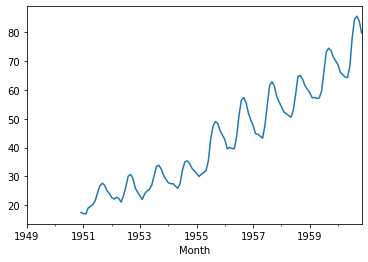

In [5]:
airlines.rolling(24).std().plot();

using the previous plot, we can confirm that the variance of this time series increases throughout time. As such, let's use the multiplicative model for decomposition

In [6]:
decomposition = seasonal_decompose(airlines, model='multiplicative')
decomposition

with this object, we have access to the estimation of the following components: 
* Trend-Cyclical
* Seasonal
* Irregular

statsmodel includes a function to plot all 3 components at once

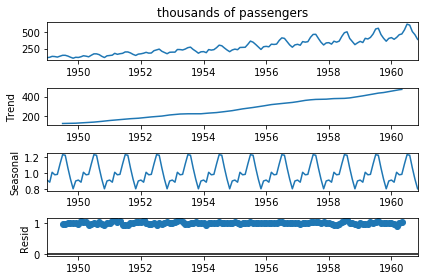

In [7]:
decomposition.plot()
plt.show()

also, we have direct access to all 3 components

In [8]:
decomposition.trend.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
Name: trend, dtype: float64

In [9]:
decomposition.seasonal.head(10)

Month
1949-01-01    0.910347
1949-02-01    0.883739
1949-03-01    1.007496
1949-04-01    0.976032
1949-05-01    0.981504
1949-06-01    1.111376
1949-07-01    1.226713
1949-08-01    1.220068
1949-09-01    1.060628
1949-10-01    0.921876
Name: seasonal, dtype: float64

In [10]:
decomposition.resid.head(10)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.951542
1949-08-01    0.953279
1949-09-01    1.002091
1949-10-01    1.003899
Name: resid, dtype: float64

Let's see some more examples:

In [11]:
mysterious_data_1 = load_electricity_consumption_series()['consumption']
mysterious_data_2 = pd.Series([gauss(0.0, 1.0) for i in range(1000)])
mysterious_data_2.name = 'White noise'
mysterious_data_2.index = pd.date_range(pd.datetime(1971, 12, 25, hour=12, minute=0), periods=1000, freq='3d')

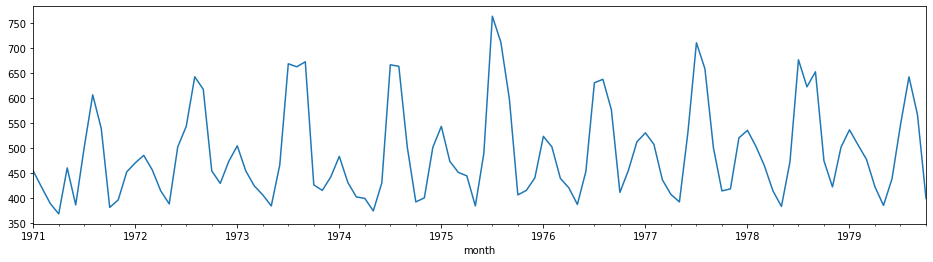

In [12]:
mysterious_data_1.plot(figsize=(16, 4));

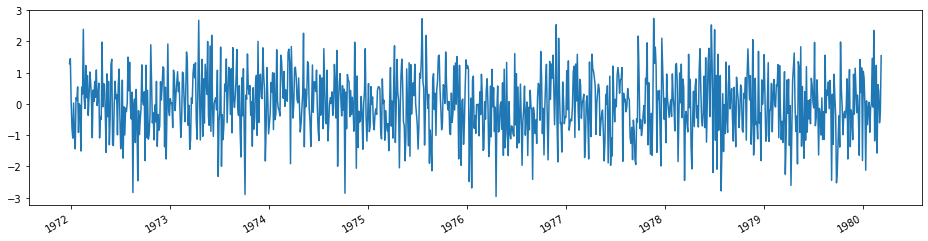

In [13]:
mysterious_data_2.plot(figsize=(16, 4));

This already gives us a visual clue that we seem to have more structure in the first one.

We can continue to search for structure by decomposing the signal, as you've learned in the previous notebook: 

##### Mysterious data 1 

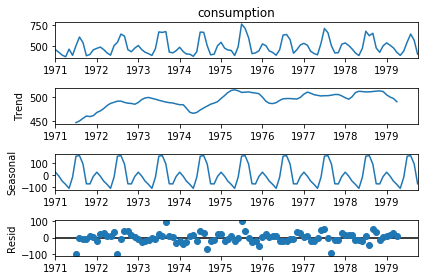

In [14]:
decomposition = seasonal_decompose(mysterious_data_1, model='additive')
decomposition.plot()
plt.show()

##### Mysterious data 2

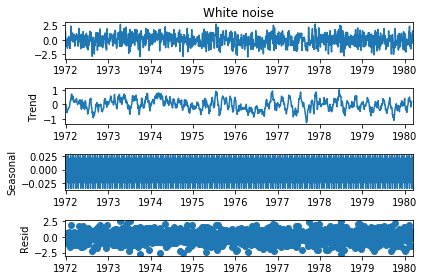

In [15]:
decomposition = seasonal_decompose(mysterious_data_2, model='additive')
decomposition.plot()
plt.show()

Well.. **_`mysterious data 2`_** seems more mysterious than **_`mysterious data 1`_**, but this is all very subjective and possibly misleading. Maybe we have a more objective way to look for structure? 

## 2. Autocorrelation

In the last BLU we manually checked the correlation for each lagged version of the timeseries: Without knowing we were looking at the ACF, which stands for auto correlation function! Here, we're going to learn about ACF, its cousin PACF and how to calculate them more expeditely.


### 2.1 ACF

[ACF](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula/129374#129374) stands for auto correlation function. 

The idea, in plain English, is very simple: _"how correlated is each datapoint, to the datapoints lagged x periods?"_

#### 2.1.1 ACF by hand

Original dataset: 

In [16]:
mysterious_data_1.head()

month
1971-01-01    454.0
1971-02-01    421.0
1971-03-01    389.0
1971-04-01    368.0
1971-05-01    460.0
Name: consumption, dtype: float64

Dataset, lagged by 1 period: 

In [17]:
mystery_lag_1 = mysterious_data_1.shift(1)
mystery_lag_1.head()

month
1971-01-01      NaN
1971-02-01    454.0
1971-03-01    421.0
1971-04-01    389.0
1971-05-01    368.0
Name: consumption, dtype: float64

So... the data that was at `1971-01-01` is now at `1971-02-01`, and so on and so forth. Fancy. 

How correlated are `mystery` and `mystery_lag_1`? 

In [18]:
mysterious_data_1.corr(mysterious_data_1.shift(1))

0.5262475690238556

Ok... how about if we lag it two times? 

In [19]:
mysterious_data_1.corr(mysterious_data_1.shift(2))

-0.14550472700327163

Negatively correlated. Let's get a bunch of these, for different values: 

In [20]:
corrs = {}
for lag in range(40):
    corrs[lag] = mysterious_data_1.corr(mysterious_data_1.shift(lag))

In [21]:
pd.Series(corrs).head()

0    1.000000
1    0.526248
2   -0.145505
3   -0.490220
4   -0.334527
dtype: float64

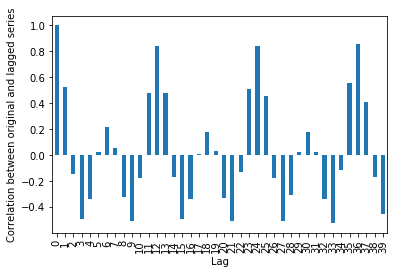

In [22]:
pd.Series(corrs).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

Wooow! We can see the structure! Every 12 months (year!) we get really high correlation, and maybe even some yearly seasons here. Cool bananas. 

#### 2.1.2 ACF with stats model 

ACF is so useful, that statsmodel actually comes with functions to calculate and to draw them. It also gives you something super useful, which are pre-calculated confidence intervals to get an idea of how significant the auto-correlation is:

In [23]:
# I'm allowed to import stuff in the middle of the notebook, and you aren't. Muahahaha! 
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [24]:
acf(mysterious_data_1)

array([ 1.        ,  0.52351648, -0.14388441, -0.47602432, -0.32189455,
        0.02128615,  0.20982187,  0.05729749, -0.29908263, -0.47353522,
       -0.16368264,  0.44064126,  0.77413446,  0.44222172, -0.14789621,
       -0.44085934, -0.29582641,  0.00320722,  0.15036108,  0.02568834,
       -0.27648917, -0.42271539, -0.10742918,  0.42150384,  0.69487689,
        0.37373687, -0.14384039, -0.40653345, -0.24083661,  0.01202592,
        0.13232417,  0.01821818, -0.24277425, -0.368318  , -0.07880223,
        0.38539143,  0.59142252,  0.28059546, -0.11759289, -0.30717932,
       -0.18906618])

Well that's what we just saw by hand. And the plot? 

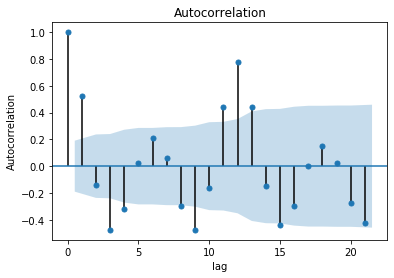

In [25]:
plot_acf(mysterious_data_1, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Preeettyyyyy.... 

The shaded area is the confidence bound. By passing the parameter `alpha=0.05` we told the plot to give us the 95% confidence interval. 

(Remember! If you're 95% confident, then you're going to be wrong once every 20 times, so take the confidence interval with that pinch of salt.)

By looking at this plot we can tell that there is some clear seasonal behavior, and that it is quite significant around the 12 mark. 

But what if we want to see more lags? Statsmodels' got that covered:

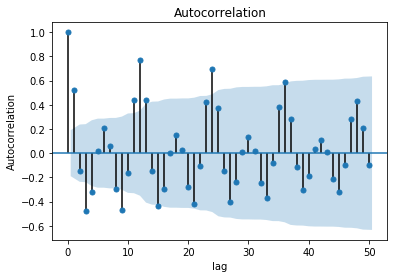

In [26]:
plot_acf(mysterious_data_1, alpha=.05, lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

##### What happens if there is no structure? 

So, we said this helped find structure. What happens if we apply this to the sneaky looking `mysterious_data_2`? 

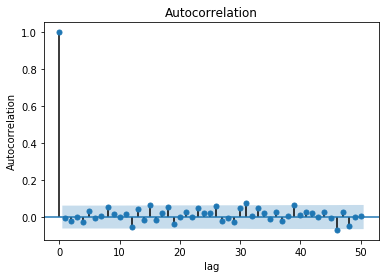

In [27]:
plot_acf(mysterious_data_2, alpha=.05, lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

That, ladies and gentlemen, is how you know that noise, is noise :)

### 2.2 PACF

[PACF](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula/129374#129374) stands for Partial Auto Correlation Function.

To illustrate the point of this, I'm going to plot the **old ACF** for `mysterious_data_1`: 

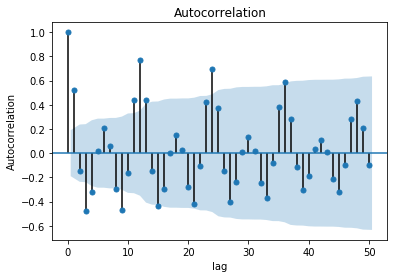

In [28]:
plot_acf(mysterious_data_1, alpha=.05, lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Isn't there something annoying about this plot? Lag 12 has a high auto-correlation. But so does lag 24. And lag 36.  So we're kind of "recycling" auto-correlation from the previous year. 

Walk into a room and tell your boss the following, and you might rightfully be laughed at:
> _"I've found something! The patterm seems to happen ever week, and every two weeks, and every 3 weeks, and every 4 weeks!"_



So what we want is to remove the autocorrelation that we've already accounted for, and plot just the "unacounted for" stuff. That's the Partial Autocorrelation Function. 

In [29]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

/Users/felgueira/Library/Python/3.7/lib/python/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


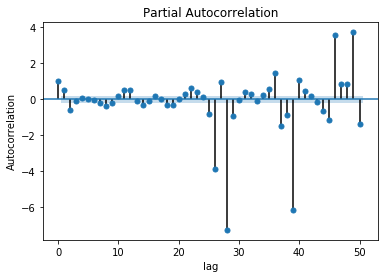

In [30]:
plot_pacf(mysterious_data_1, alpha=0.05, lags=50)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Ooops! It seems like we've got a warning from _statsmodels_. Also, the values of the PACF are outside the [-1,1] bounds, which is **impossible**. This is a well known numerical problem that can occur due to the approximations in the calculations. A quick way to solve is to change the underlying method to calculate the PACF:

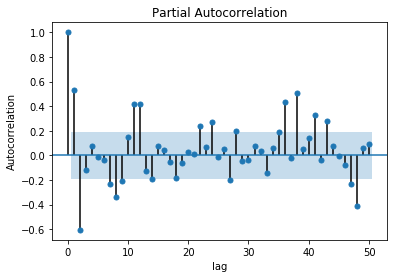

In [31]:
plot_pacf(mysterious_data_1, alpha=0.05, lags=50, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Ok, now it makes sense. The PACF is similar to the ACF but without the repeating correlation lags. So basically, the PACF is showing us the ACF but penalizing seasonality-related autocorrelation. Why do we want this you ask? Well because we already know there is seasonality with lag 12, but we also want to find more possible correlations. In the ACF these get camouflaged by the effect of seasonality. On the PACF we can see much more interesting lags, like lag 2 for example with -0.6 autocorrelation, whilst it only had -0.2 on the ACF.

## 3. Stationarity

The concept of autocorrelation is essential for modelling time series, but at least as important is understanding what is stationarity.

For the math nerds: https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity

For the others, a brief explanation:

> **_"A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time."_**

Stationarity is a holy grail in timeseries, specially if you are using the type of models we will show you next. If a process is stationary, then you can make cool predictions. We can (and will) transform our timeseries until they are stationary processes.

First, let's look at a clearly non stationary timeseries, our old friend airlines dataset:

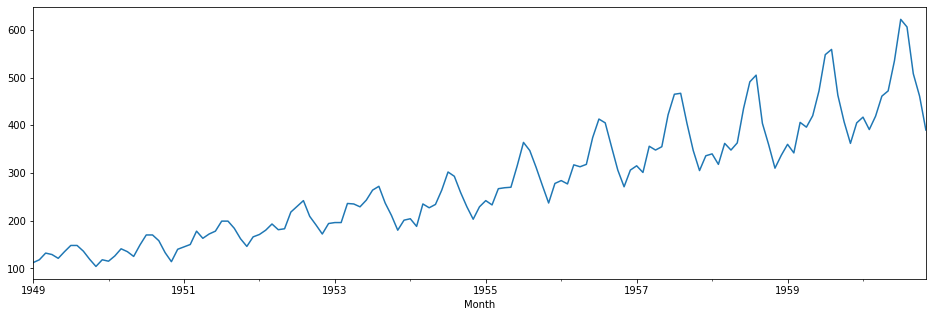

In [32]:
airlines.plot(figsize=(16, 5))

#### Is the mean constant over time? 
Nop. 

#### Is the variance constant over time? 
Oh hell no.

#### Is the auto-correlation constant over time? 
Probably not...

Let's beat this timeseries into submission until it becomes stationary! 

## 3.1 Stabilize Variance

First, we should stabilize the variance so that it is approximatelly constant over time. The most common way to do that, is to apply the log transform, which is just a special case of the [box-cox transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html). For those interested, it's definitely worth exploring further. So let's see how log changes our timeseries

In [33]:
airlines_logged = airlines.map(np.log)

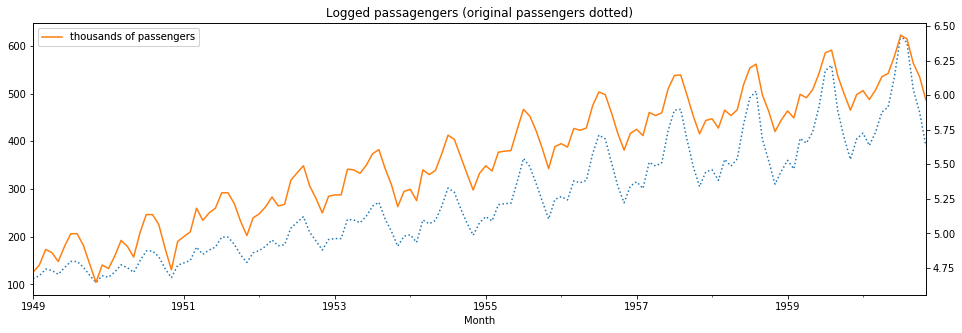

In [34]:
airlines.plot(legend='Original', ls=':')
airlines_logged.plot(figsize=(16, 5), secondary_y=True)
plt.title('Logged passagengers (original passengers dotted)')
plt.legend()
plt.show()

Notice that the variance in the original timeseries kept growing, but our logged timeseries has constant variance! 

## 3.2 Removing trend 

The next step is to remove the trend, so that the means of the timeseries is approximatelly constant over time. A trivial way to remove the trend is to take the lag 1, and subtract it. In other words, instead of using the series, we will use the difference beween consecutive observations. 

Difference, you say? difference... Ah! [Diff!](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwj2kvHgif7aAhUCyRQKHRdSAkYQFggpMAA&url=http%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fversion%2F0.17%2Fgenerated%2Fpandas.Series.diff.html&usg=AOvVaw2vcM6MwJhG4ku5Bvpkgn8p)

In [35]:
airlines_logged_diff = airlines_logged.diff()

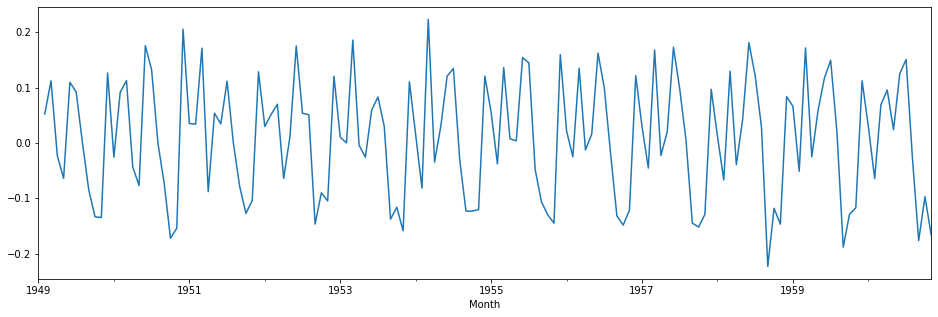

In [36]:
airlines_logged_diff.plot(figsize=(16, 5))

Hmm... mean looks constant over time, variance seems constant over time... looks like we managed! 

Note: it's advised to do the log transform first, and then the diff. The reason is that the diff has a tendency to place results at zero, which will prove problematic with the log transform. 

## 3.3 Other methods 

This was clearly an easy timeseries to make stationary. Most timeseries require a lot more work. There are approaches such as removing a moving average that are more powerful, and tend to work quite well. 

However, remember this: whatever transformation you do to your timeseries in your attempt to make it stationary should be one you can reverse later. If your boss asks you 
> _"How many passengers are we going to have next sunday?"_


Answering this won't get you far: 
> _"On next sunday, I predict a logged diff of -0.23."_

So whenever you are transforming your timeseries, you need to keep these transformations reversible, and the more complex the transformation, the more complex it is to invert. 

## 3.4 Evaluating stationarity 

Is it stationary? It... "looks stationary". 

But, as with so many things in life, when you need to quantify them, generally you'll find that [there is a way](https://i.imgflip.com/2a3kei.jpg). 

For that, we use the **[Dickey-Fuller test](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)**: 

In [37]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

The Dickey-Fuller test has the null hypothesis that the [Unit Root](https://en.wikipedia.org/wiki/Unit_root) is present. The details of this are interesting yet out of scope, but suffice it to say for our purposes that if the unit root isn't present, the timeseries can be assumed to be stationary. 

So, for the time being, "_Unit Root is bad_ ", and "_no Unit Root is good_ ". Only if the p-value is below a critical size, do we have statistical evidence to reject the unit root. Thus, there is statistical evidence that our series is stationary.
 
 So... we want a low p value. Got that? Great. 

So let's just pass it our series... 

In [38]:
try: 
    adfuller(airlines_logged_diff)
except Exception as e:
    print('NEIN! And here is why: %s' % e)
    

NEIN! And here is why: exog contains inf or nans


Ah damn it. The reason why we have this try catch is because you're gonna run into this at some point: 

> We forgot to get rid of our missing data. The first point, remember? 

In [39]:
airlines_logged_diff.head(3)

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
Name: thousands of passengers, dtype: float64

Trying again without the missing datapoint:

In [40]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(airlines_logged_diff.dropna())

Ok, I know, so many returns. It's worth taking a look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller), but for our purposes, we're going to use it in a ridiculously simple way: 

In [41]:
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -2.71
pvalue:    0.073


The p value is low, but not as low as we normally like it to be. We can't reject that we have unit root at a 95% confidence interval, which is a good rule of thumb. For that, we'd need to have a p value < 0.05. But since this is just an example, we can leave as it is. 

If we really wanted to have a more stationary time series we could use more sophisticated ways to get rid of the trend (subtracting the rolling mean) or even diff again. But do be careful with the diffs, it's like salt, you want just enough, too much ruins the dish. 

So that's it for the basics on preparing your time series for modelling. On the next notebooks you will find out that some of this work is already done for you in certain libraries, but it's always fundamental that you have an idea of what's going on behind the scenes.

Make sure to check this [article](https://twitterdev.github.io/do_more_with_twitter_data/timeseries.html#timeseries) from Twitter's `Do More with Twitter Data` that is an excelent example of making time series analysis.